# Case Study: Symbolic Regression

Fig. 6e

Directory to store the downloaded causal chamber datasets.

In [1]:
DOWNLOAD_DIR = '/tmp'

In [2]:
import sys
sys.path = ['../'] + sys.path
sys.path = ['src'] + sys.path

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import torch
import numpy as np
import sympy as sp
import os, sys
import symbolicregression
import requests
from IPython.display import display

from sklearn.metrics import r2_score

/home/juan/ETH/causal-chamber-paper/notebooks/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


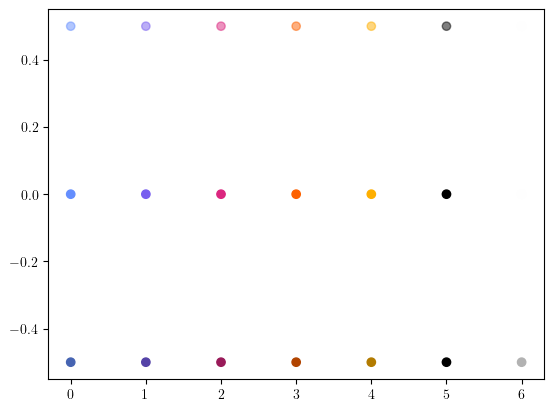

In [5]:
# Set tex formatting for plots
matplotlib.rc('text', usetex = True)
matplotlib.rc('font', **{'family' : "sans-serif"})
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')

# Set color palette
def to_rgb(H, b=1, a=1):
    RGBa = []
    for h in H:
        h = h.lstrip("#")
        RGBa.append(tuple(int(h[i:i+2], 16) / 256 * b for i in (0, 2, 4)) + (a,))
    return np.array(RGBa)

# Color palettes
ibm_color_blind = ["#648fff", "#785ef0", "#dc267f", "#fe6100", "#ffb000", "#000000", "#ffffff"]

palette = ibm_color_blind
base = to_rgb(palette)
basea = to_rgb(palette, a=0.5)
baseb = to_rgb(palette, b=0.7)
plt.scatter(np.arange(len(base)), np.zeros(len(base)), c = base)
plt.scatter(np.arange(len(base)), np.ones(len(base))*0.5, c = basea)
plt.scatter(np.arange(len(base)), np.ones(len(base))*-0.5, c = baseb)

matplotlib.rcParams.update({'font.size': 7})
MM = 1/25.4

## Download pre-trained model from https://github.com/facebookresearch/symbolicregression

See reference [1] below.

In [6]:
np.random.seed(42)
torch.manual_seed(42)

In [7]:
model_path = "model.pt" 
try:
    if not os.path.isfile(model_path): 
        url = "https://dl.fbaipublicfiles.com/symbolicregression/model1.pt"
        r = requests.get(url, allow_redirects=True)
        open(model_path, 'wb').write(r.content)
    if not torch.cuda.is_available():
        model = torch.load(model_path, map_location=torch.device('cpu'))
    else:
        model = torch.load(model_path)
        model = model.cuda()
    print(model.device)
    print("Model successfully loaded!")

except Exception as e:
    print("ERROR: model not loaded! path was: {}".format(model_path))
    print(e)    

cuda:0
Model successfully loaded!


In [8]:
from sympy import *
def round_expr(expr, num_digits=1):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(Number)})

### Define symbolic regressor

In [9]:
def fit(x,y,runs=5,n_trees=200):
    expressions = []
    estimators = []
    r2_scores = []
    for i in range(runs):
        # Fit
        est = symbolicregression.model.SymbolicTransformerRegressor(
                                model=model,
                                max_input_points=200,
                                n_trees_to_refine=n_trees,
                                rescale=True
                                )

        est.fit(x,y)
        replace_ops = {"add": "+", "mul": "*", "sub": "-", "pow": "**", "inv": "1/"}
        model_str = est.retrieve_tree(with_infos=True)["relabed_predicted_tree"].infix()
        for op,replace_op in replace_ops.items():
            model_str = model_str.replace(op,replace_op)
        expr = sp.parse_expr(model_str)
        # Store & display expressions
        expressions.append(expr)                
        # Store estimator objects
        estimators.append(est)
        # Compute r2 scores
        r2_scores.append(r2_score(y, est.predict(x)))
    return expressions,estimators,r2_scores

## Recovering Malus' law from light-intensity readings

### Load and visualize dataset

In [10]:
import causalchamber.datasets as datasets
dataset = datasets.Dataset(name="lt_malus_v1", root=DOWNLOAD_DIR)
df = dataset.get_experiment('white_255').as_pandas_dataframe()


Fetching list of available datasets from https://causalchamber.s3.eu-central-1.amazonaws.com/downloadables/directory.yaml ... done.
If you use our datasets or models for your work please consider citing:

@article{gamella2024chamber,
  title={The Causal Chambers: Real Physical Systems as a Testbed for AI Methodology},
  author={Gamella, Juan L. and B"uhlmann, Peter and Peters, Jonas},
  journal={arXiv preprint arXiv:2404.11341},
  year={2024}
}

Dataset lt_malus_v1 found in "/tmp/lt_malus_v1".


126.81193122474724 [2774.35727984]


/home/juan/ETH/causal-chamber-paper/notebooks/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:1111: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
/home/juan/ETH/causal-chamber-paper/notebooks/lib/python3.8/site-packages/mpl_toolkits/mplot3d/art3d.py:1113: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':
/home/juan/temp_cache_remove_me/ipykernel_12972/2836893368.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


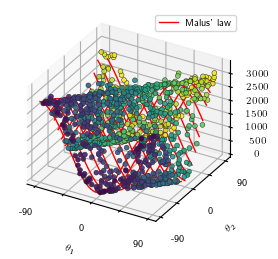

In [11]:
pol_1 = df['pol_1'].values
pol_2 = df['pol_2'].values
intensity = df['ir_3'].values

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(projection='3d')
ax.scatter(pol_1, pol_2, intensity, pol_2, c=pol_2, cmap='viridis', marker='o', alpha=0.9, s=12, edgecolor='#2a2a2a', linewidth=0.4)
#ax.view_init(25,30,'z')
ax.set_proj_type('ortho')
ax.set_xticks([-90,-45,0,45,90])
ax.set_yticks([-90,-45,0,45,90])
ax.set_xticklabels([-90,"",0,"",90])
ax.set_yticklabels([-90,"",0,"",90])
#ax.set_yticklabels([90,0,-90])
#ax.set_zticks([0,500,1000])
#ax.set_zlim([-10,30])
ax.set_xlabel(r'$\theta_1$')
ax.set_ylabel(r'$\theta_2$')
ax.set_zlabel(r'$\tilde{I}_3$')

# Contour with Malus' Law
malus = np.cos(abs((df['pol_1']  - df['pol_2']).values)/360*2*np.pi)**2
from sklearn.linear_model import LinearRegression
X = malus.reshape([-1,1])
y = df['ir_3'].values
reg = LinearRegression().fit(X, y)
print(reg.intercept_,reg.coef_)
def f(theta_1,theta_2):
    return reg.intercept_ + reg.coef_ * np.cos(abs(theta_1-theta_2) /360*2*np.pi)**2
def fd(d):
    return reg.intercept_ + reg.coef_ * np.cos(d /360*2*np.pi)**2

lo = -90
hi = 90
delta=10
cmap = matplotlib.cm.get_cmap('viridis')
x = np.array(sorted(pol_1))
for i in range(lo,hi,delta):
    y = np.ones_like(x)*i
    z = f(x,y)
    color = cmap((i+180)/360)
    color = color[0:3] + (0.3,)
    color='red'
    ax.plot3D(x,y,z, color=color, label="Malus' law" if i == hi - delta else None, linewidth=1) 
plt.legend()
plt.savefig("../figures/symb_regression_malus.pdf", bbox_inches="tight")

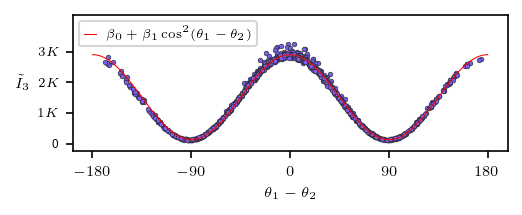

In [12]:
fig = plt.figure(figsize=(95*MM,30*MM), dpi=150)
x = np.linspace(-180,180,500)
plt.plot(x,fd(x),color='red', linewidth=0.5, linestyle='-', label=r"$\beta_0 + \beta_1\cos^2(\theta_1 - \theta_2)$")
kwargs = {'marker': 'o', 's':5, 'edgecolor': '#2a2a2a', 'linewidth': 0.3}
plt.scatter(df['pol_1'] - df['pol_2'], df.ir_3, color=base[1],**kwargs)
plt.xlabel(r"$\theta_1  - \theta_2$")
plt.ylabel(r"$\tilde{I}_3$", rotation=0, va="center", ha="right")
plt.yticks([0,1000,2000,3000], ["0", "$1K$", "$2K$", "$3K$"], size=6)
plt.xticks([-180,-90,0,90,180])

plt.legend(ncol=2, prop={'size':6}, handlelength=1, loc="upper left")# loc="lower center", bbox_to_anchor=(0.5, 1), handlelength=1
plt.ylim([-250,4200])

plt.savefig("../figures/malus_real.pdf", bbox_inches="tight")

### Fit symbolic regressor

In [13]:
%%time
x = df[['pol_1', 'pol_2']].values * np.pi / 180
y = df.ir_3.values.copy()
expressions, estimators, r2_scores = fit(x,y)

CPU times: user 22min 2s, sys: 1min 23s, total: 23min 25s
Wall time: 3min 24s


In [14]:
for e in expressions:
    display(round_expr(e, 1))

2858.8*cos(1.0*x_0 - 1.0*x_1)**2 + 140.5 + 8.7/(81.7 + 0.1/(84.2*x_0 - 4.1))

-6.9*x_0 - 6.8*x_1 + 2805.8*sin(1.0*x_0 - 1.0*x_1 + 1.6)**2 + 114.4 + 1.36226e-5/(x_1 + 0.1)**2

3.3*sin(45.7*x_0 + 46.6)**2 + 2719.1*cos(0.9*x_0 - 1.0*x_1)**2 + 88.0

2818.7*cos(1.0*x_0 - 1.0*x_1 + 0.1)**2 + 120.1

-0.96*x_0 + 8.6*exp(1.0*x_1) + 1.48e+3*sin(-2.0*x_0 + 1.9*x_1 + 7.8) + 1.51e+3

In [15]:
for e,r in zip(expressions,r2_scores):
    expr = r"(R^2 =%0.2f" % r + r")\quad \tilde{I}_3 = &" + latex(round_expr(e,1)) + r"\\"
    expr = expr.replace("x_{0}", r"\theta_1")
    expr = expr.replace("x_{1}", r"\theta_2")
    print(expr)

(R^2 =0.98)\quad \tilde{I}_3 = &2858.8 \cos^{2}{\left(1.0 \theta_1 - 1.0 \theta_2 \right)} + 140.5 + \frac{8.7}{81.7 + \frac{0.1}{84.2 \theta_1 - 4.1}}\\
(R^2 =0.99)\quad \tilde{I}_3 = &- 6.9 \theta_1 - 6.8 \theta_2 + 2805.8 \sin^{2}{\left(1.0 \theta_1 - 1.0 \theta_2 + 1.6 \right)} + 114.4 + \frac{1.36226 \cdot 10^{-5}}{\left(\theta_2 + 0.1\right)^{2}}\\
(R^2 =0.97)\quad \tilde{I}_3 = &3.3 \sin^{2}{\left(45.7 \theta_1 + 46.6 \right)} + 2719.1 \cos^{2}{\left(0.9 \theta_1 - 1.0 \theta_2 \right)} + 88.0\\
(R^2 =0.99)\quad \tilde{I}_3 = &2818.7 \cos^{2}{\left(1.0 \theta_1 - 1.0 \theta_2 + 0.1 \right)} + 120.1\\
(R^2 =0.98)\quad \tilde{I}_3 = &- 0.96 \theta_1 + 8.6 e^{1.0 \theta_2} + 1.48 \cdot 10^{3} \sin{\left(- 2.0 \theta_1 + 1.9 \theta_2 + 7.8 \right)} + 1.51 \cdot 10^{3}\\


In [16]:
r2_scores

[0.9814651698466864,
 0.9908708460365628,
 0.9726065989345528,
 0.9897233213782987,
 0.9808669009336707]

### Compare to performance on synthetic data

Data is produced from the ground-truth expression (Malu's law, see model E1 in Appendix IV.2.1) with added Gaussian noise

In [17]:
def sample_model(std=50, seed=42):
    rng = np.random.default_rng(seed)
    sample = np.zeros((len(df),3))
    sample[:,0:2] = df[['pol_1', 'pol_2']].values
    for i,(theta_1, theta_2) in enumerate(df[['pol_1', 'pol_2']].values):
        # f has already been fit above to the data        
        sample[i,2] = f(theta_1, theta_2)
    sample[:,2] += rng.normal(loc=0, scale=std, size=len(sample))
    return sample

In [18]:
sample = sample_model()

In [19]:
reg.intercept_ , reg.coef_

(126.81193122474724, array([2774.35727984]))

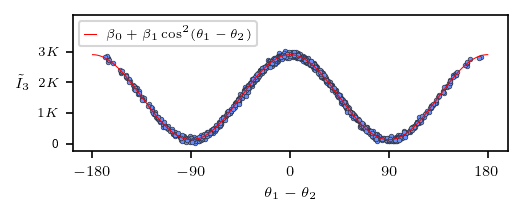

In [20]:
fig = plt.figure(figsize=(95*MM,30*MM), dpi=150)
x = np.linspace(-180,180,500)
plt.plot(x,fd(x),color='red', linewidth=0.5, linestyle='-', label=r"$\beta_0 + \beta_1\cos^2(\theta_1 - \theta_2)$")
kwargs = {'marker': 'o', 's':5, 'edgecolor': '#2a2a2a', 'linewidth': 0.3}
plt.scatter(sample[:,0] - sample[:,1], sample[:,2], color=base[0],**kwargs)
plt.xlabel(r"$\theta_1  - \theta_2$")
plt.ylabel(r"$\tilde{I}_3$", rotation=0)
plt.ylabel(r"$\tilde{I}_3$", rotation=0, va="center", ha="right")
plt.yticks([0,1000,2000,3000], ["0", "$1K$", "$2K$", "$3K$"], size=6)
plt.xticks([-180,-90,0,90,180])
plt.legend(ncol=2, prop={'size':6}, handlelength=1, loc="upper left")# loc="lower center", bbox_to_anchor=(0.5, 1), handlelength=1
plt.ylim([-250,4200])


plt.savefig("../figures/malus_synthetic.pdf", bbox_inches="tight")

#### Fit symbolic regressor to synthetic data

In [21]:
%%time
x = sample[:,0:2] * np.pi / 180
y = sample[:,2]
expressions_syn, estimators_syn, r2_scores_syn = fit(x,y)

CPU times: user 22min 11s, sys: 1min 28s, total: 23min 40s
Wall time: 3min 18s


In [22]:
for e in expressions_syn:
    display(round_expr(e, 1))

2887.1*cos(1.0*x_0 - 1.0*x_1)**2 + 80.2

2887.1*cos(1.0*x_0 - 1.0*x_1)**2 + 80.2

2887.1*cos(1.0*x_0 - 1.0*x_1)**2 + 80.2

2887.1*cos(1.0*x_0 - 1.0*x_1)**2 + 80.2

2887.1*cos(1.0*x_0 - 1.0*x_1)**2 + 80.2

In [23]:
for e,r in zip(expressions_syn,r2_scores_syn):
    expr = r"(R^2 =%0.2f" % r + r")\quad \tilde{I}_3 = &" + latex(round_expr(e,1)) + r"\\"
    expr = expr.replace("x_{0}", r"\theta_1")
    expr = expr.replace("x_{1}", r"\theta_2")
    print(expr)

(R^2 =0.99)\quad \tilde{I}_3 = &2887.1 \cos^{2}{\left(1.0 \theta_1 - 1.0 \theta_2 \right)} + 80.2\\
(R^2 =0.99)\quad \tilde{I}_3 = &2887.1 \cos^{2}{\left(1.0 \theta_1 - 1.0 \theta_2 \right)} + 80.2\\
(R^2 =0.99)\quad \tilde{I}_3 = &2887.1 \cos^{2}{\left(1.0 \theta_1 - 1.0 \theta_2 \right)} + 80.2\\
(R^2 =0.99)\quad \tilde{I}_3 = &2887.1 \cos^{2}{\left(1.0 \theta_1 - 1.0 \theta_2 \right)} + 80.2\\
(R^2 =0.99)\quad \tilde{I}_3 = &2887.1 \cos^{2}{\left(1.0 \theta_1 - 1.0 \theta_2 \right)} + 80.2\\


## Recovering Bernoulli's principle from barometric readings

### Load and visualize data

In [24]:
import causalchamber.datasets as datasets
dataset = datasets.Dataset(name="wt_bernoulli_v1", root=DOWNLOAD_DIR)
df = dataset.get_experiment('random_loads_intake').as_pandas_dataframe().sample(n=1000, random_state=42) # Reduce sample size to reduce runtime of symbolic regressor
df_off = dataset.get_experiment('fans_off').as_pandas_dataframe()

Dataset wt_bernoulli_v1 found in "/tmp/wt_bernoulli_v1".


Estimate barometer offset using measurements from both fans turned off

Offset: -7.100861979166667


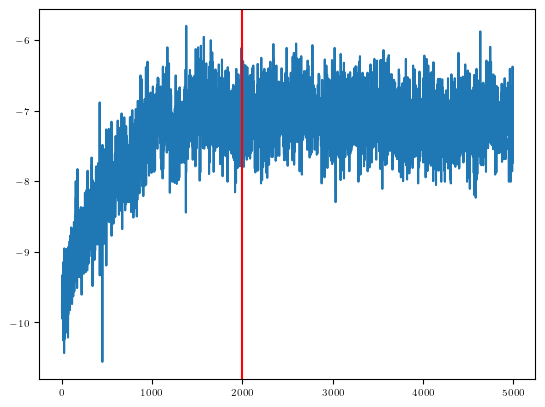

In [25]:
cutoff = 2000
plt.plot(df_off.pressure_downwind - df_off.pressure_upwind)
plt.gca().axvline(cutoff, color='red')
offset = (df_off.pressure_downwind - df_off.pressure_upwind).iloc[cutoff:].mean()
print("Offset:", offset)

### Bernoulli's principle

$P_{up} - P_{dw} = \frac{1}{2} \rho v^2$

$\tilde{P}_{up} - \tilde{P}_{dw} \sim \frac{1}{2} \rho v^2 + \Delta$

where
- $\Delta$ is the offset in the barometer readings
- $v$ is the speed of the airflow through the tunnel
- $\rho$ is the air density

because airflow scales linearly with the fan speed $\tilde{\omega}_\text{in}$, we can fit the model

$P_{dw} - P_{up} \sim \frac{1}{2} \rho \beta v_{ch}^2 + \Delta$

and we take $\rho = 1.2$ based on the local weather conditions at the time of the experiment.

In [26]:
# Extract mean rpms, pressures and compute difference between up and downwind barometer
rpm = df.groupby('flag')['rpm_in'].mean().values / 3000
p_dw = df.groupby('flag')['pressure_downwind'].mean().values
p_up = df.groupby('flag')['pressure_upwind'].mean().values
diff = p_up - p_dw + offset

# Fit ground-truth model (Bernoulli's principle)
from sklearn.linear_model import LinearRegression
X = rpm.reshape([-1,1])
reg = LinearRegression().fit(X**2, diff)
def f(r):
    return reg.intercept_ + reg.coef_ * r**2
print(reg.intercept_, reg.coef_)

-0.40394424242910265 [11.79203787]


In [27]:
cmap = matplotlib.cm.get_cmap('viridis')
residuals = abs(diff - f(rpm))
color = [cmap(r/residuals.max() * 1.5) for r in residuals]

/home/juan/temp_cache_remove_me/ipykernel_12972/1782591924.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('viridis')


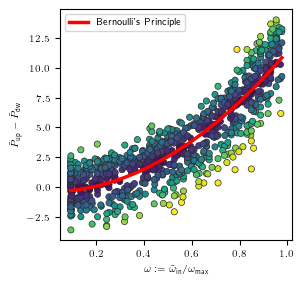

In [28]:
fig = plt.figure(figsize=(3,3))
plt.scatter(rpm, diff, marker='o', s=20, edgecolor="#2a2a2a", linewidth=0.5, c = color)
x = np.linspace(rpm.min(),rpm.max(),100)
plt.plot(x, f(x), color="red", linewidth=2.5, label="Bernoulli's Principle")#label="$%0.2f$" % reg.coef_[0] + r"$\times \omega^2$" + "$ %0.2f$" % reg.intercept_)
plt.xlabel(r"$\omega := \tilde{\omega}_\text{in} / \omega_\text{max}$")
plt.ylabel(r"$\tilde{P}_\text{up} - \tilde{P}_\text{dw}$")
plt.legend()
plt.savefig("../figures/symb_regression_bernoulli.pdf", bbox_inches="tight")

### Fit symbolic regressor to real data

In [29]:
np.random.seed(42)
torch.manual_seed(42)

In [30]:
%%time
x = np.atleast_2d(rpm).T
y = diff
expressions, estimators, r2_scores = fit(x,y,n_trees=200)

CPU times: user 15min 37s, sys: 1.96 s, total: 15min 39s
Wall time: 2min 23s


In [31]:
for e in expressions:
    display(round_expr(e, 1))

7.2*((-(x_0 + 0.2)**2 - 0.1*sin(1.5*x_0 - 0.8))**2)**0.5 - 0.e-1*tan(14.0*sin(19.6*x_0 - 10.3)) - 0.8

(-2.3*x_0 - 0.2)*(-5.8*x_0 + cos(285.3*x_0 - 148.8) + 2.3) + 2.12

10.1*x_0**2 - 0.6015625*(0.1 - cos(81.0*Abs(340.4*x_0 - 171.0) + 4.5))**3 + 0.42

6.7*x_0**2*(1 + 0.4*exp(-0.e-1/(4.2 - 3.1*Abs(31.6*x_0 - 16.5))))**2 + 1.2*sin(4668785.1*(x_0 - 0.6)**2)

1.0*exp(2.7*x_0 - 0.8/(4.9 + 1.4/(248622.0*(x_0 - 0.5)**4 - 5.8))) + 0.1

In [32]:
for e,r in zip(expressions,r2_scores):
    expr = r"(R^2 =%0.2f" % r + r")\quad \Delta P = &" + latex(round_expr(e,1)) + r"\\"
    expr = expr.replace("x_{0}", r"\omega")
    print(expr)

(R^2 =0.72)\quad \Delta P = &7.2 \left(\left(- \left(\omega + 0.2\right)^{2} - 0.1 \sin{\left(1.5 \omega - 0.8 \right)}\right)^{2}\right)^{0.5} - 0.09 \tan{\left(14.0 \sin{\left(19.6 \omega - 10.3 \right)} \right)} - 0.8\\
(R^2 =0.68)\quad \Delta P = &\left(- 2.3 \omega - 0.2\right) \left(- 5.8 \omega + \cos{\left(285.3 \omega - 148.8 \right)} + 2.3\right) + 2.12\\
(R^2 =0.76)\quad \Delta P = &10.1 \omega^{2} - 0.6015625 \left(0.1 - \cos{\left(81.0 \left|{340.4 \omega - 171.0}\right| + 4.5 \right)}\right)^{3} + 0.42\\
(R^2 =0.72)\quad \Delta P = &6.7 \omega^{2} \left(1 + 0.4 e^{- \frac{0.09}{4.2 - 3.1 \left|{31.6 \omega - 16.5}\right|}}\right)^{2} + 1.2 \sin{\left(4668785.1 \left(\omega - 0.6\right)^{2} \right)}\\
(R^2 =0.75)\quad \Delta P = &1.0 e^{2.7 \omega - \frac{0.8}{4.9 + \frac{1.4}{248622.0 \left(\omega - 0.5\right)^{4} - 5.8}}} + 0.1\\


### Compare to performance on synthetic data

Data is produced from the ground-truth expression (Malu's law, see model E1 in Appendix IV.2.1) with added Gaussian noise

In [33]:
def sample_model(std=1.5, seed=42): # 1.5
    rng = np.random.default_rng(seed)
    sample = np.zeros((len(df),2))
    sample[:,0] = df.rpm_in.values / 3000
    sample[:,1] = f(sample[:,0])    
    sample[:,1] += rng.normal(loc=0, scale=std, size=len(sample))
    return sample

In [34]:
sample = sample_model()

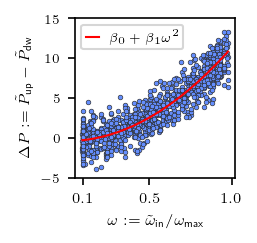

In [35]:
fig = plt.figure(figsize=(35*MM,35*MM), dpi=150)
x = np.linspace(rpm.min(),rpm.max(),100)
plt.plot(x,f(x),color='red', linewidth=1, linestyle='-', label=r"$\beta_0 + \beta_1\omega^2$")
kwargs = {'marker': 'o', 's':5, 'edgecolor': '#2a2a2a', 'linewidth': 0.3}
plt.scatter(sample[:,0], sample[:,1], color=base[0],**kwargs)
plt.xlabel(r"$\omega := \tilde{\omega}_\text{in} / \omega_\text{max}$")
plt.ylabel(r"$\Delta P := \tilde{P}_\text{up} - \tilde{P}_\text{dw}$")
plt.yticks([-5,0,5,10,15], size=6)
plt.xticks([0.1,0.5,1])
plt.legend(ncol=2, prop={'size':6}, handlelength=1, loc="upper left")# loc="lower center", bbox_to_anchor=(0.5, 1), handlelength=1
plt.ylim([-5,15])

plt.savefig("../figures/bernoulli_synthetic.pdf", bbox_inches="tight")

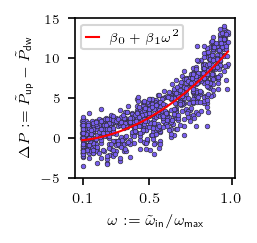

In [36]:
fig = plt.figure(figsize=(35*MM,35*MM), dpi=150)
x = np.linspace(rpm.min(),rpm.max(),100)
plt.plot(x,f(x),color='red', linewidth=1, linestyle='-', label=r"$\beta_0 + \beta_1\omega^2$")
kwargs = {'marker': 'o', 's':5, 'edgecolor': '#2a2a2a', 'linewidth': 0.3}
plt.scatter(rpm, diff, color=base[1],**kwargs)
plt.xlabel(r"$\omega := \tilde{\omega}_\text{in} / \omega_\text{max}$")
plt.ylabel(r"$\Delta P := \tilde{P}_\text{up} - \tilde{P}_\text{dw}$")
#plt.ylabel(r"$\tilde{I}_3$", rotation=0, va="center", ha="right")
plt.yticks([-5,0,5,10,15], size=6)
plt.xticks([0.1,0.5,1])
plt.legend(ncol=2, prop={'size':6}, handlelength=1, loc="upper left")# loc="lower center", bbox_to_anchor=(0.5, 1), handlelength=1
plt.ylim([-5,15])

plt.savefig("../figures/bernoulli_real.pdf", bbox_inches="tight")

In [37]:
std_y, std_x = sample.std(axis=0)
mean_x, mean_y = sample.mean(axis=0)
mean_x, std_x

(0.5301330400187174, 3.747568417231485)

#### Fit symbolic regressor to synthetic data

In [38]:
%%time
x = sample[:,[0]]
y = sample[:,1]
expressions_syn, estimators_syn, r2_scores_syn = fit(x,y)

/home/juan/ETH/causal-chamber-paper/notebooks/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:141: RuntimeWarning: invalid value encountered in scalar divide
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/home/juan/ETH/causal-chamber-paper/notebooks/lib/python3.8/site-packages/scipy/optimize/_linesearch.py:141: RuntimeWarning: invalid value encountered in scalar subtract
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


CPU times: user 17min 35s, sys: 3min 7s, total: 20min 43s
Wall time: 2min 58s


In [39]:
for e in expressions_syn:
    display(round_expr(e, 1))

14.0*x_0 - 3.9

-2.1*sin(-2.5*x_0 + 0.5*tan(864455.9*(1 - 0.3*x_0)**2 + 7.1) + 1.4) + 7.0*Abs((0.3*x_0 - 0.e-1)*(0.8*sin(26.9*x_0 - 14.2) + 6.2)) - 0.2

1.1*arctan(-3.8*tan(0.3 + 58.2/(25.7*x_0 - 13.4))) + 62.8*Abs(0.2*x_0 - 0.e-1)

(3.1*x_0 + 2.0)*(3.2*x_0 - 1.7) - 4.2*(0.1*Abs(35.6*sin(0.3/cos(131.8*x_0 - 69.9)) + 0.1) + 1)**0.5 + 10.3

7.3*x_0 + 14.3*(x_0 - 0.1*sin(0.7*tan(124.2*x_0 - 65.8) - 63.6) - 0.3)**2 - 1.8

In [40]:
for e,r in zip(expressions_syn,r2_scores_syn):
    rpm = df.groupby('flag')['rpm_in'].mean().values / 3000
    p_dw = df.groupby('flag')['pressure_downwind'].mean().values
    p_up = df.groupby('flag')['pressure_upwind'].mean().values
    diff = p_up - p_dw + offset
    expr = r"(R^2 =%0.2f" % r + r")\quad \DeltaP = &" + latex(round_expr(e,1)) + r"\\"
    expr = expr.replace("x_{0}", r"\omega")    
    print(expr)

(R^2 =0.71)\quad \DeltaP = &14.0 \omega - 3.9\\
(R^2 =0.69)\quad \DeltaP = &- 2.1 \sin{\left(- 2.5 \omega + 0.5 \tan{\left(864455.9 \left(1 - 0.3 \omega\right)^{2} + 7.1 \right)} + 1.4 \right)} + 7.0 \left|{\left(0.3 \omega - 0.09\right) \left(0.8 \sin{\left(26.9 \omega - 14.2 \right)} + 6.2\right)}\right| - 0.2\\
(R^2 =0.66)\quad \DeltaP = &1.1 \arctan{\left(- 3.8 \tan{\left(0.3 + \frac{58.2}{25.7 \omega - 13.4} \right)} \right)} + 62.8 \left|{0.2 \omega - 0.09}\right|\\
(R^2 =0.74)\quad \DeltaP = &\left(3.1 \omega + 2.0\right) \left(3.2 \omega - 1.7\right) - 4.2 \left(0.1 \left|{35.6 \sin{\left(\frac{0.3}{\cos{\left(131.8 \omega - 69.9 \right)}} \right)} + 0.1}\right| + 1\right)^{0.5} + 10.3\\
(R^2 =0.76)\quad \DeltaP = &7.3 \omega + 14.3 \left(\omega - 0.1 \sin{\left(0.7 \tan{\left(124.2 \omega - 65.8 \right)} - 63.6 \right)} - 0.3\right)^{2} - 1.8\\


## References

[1] Kamienny PA, d'Ascoli S, Lample G, Charton F. End-to-end symbolic regression with transformers. Advances in Neural Information Processing Systems. 2022 Dec 6;35:10269-81.